In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import grad, jit, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value

from pu.pu_dynamics import *
from pu.load_data import *

from functools import partial
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#Let's load scaled versions of all the data that we need
data_path = "../data" #Location where all data is stored

rhokl = [1,2,3]
macl = [1,2,3,4,5,6]
neutl = [1,2,3,4,5,6]
kcl = [1,2,3,4,5]
tal = [1,2,3]
tbl = [1,2,3,4,5,6]

dat_mac = load_file(data_path, "Macro", macl, 30)
dat_neut = load_file(data_path, "Neutro", neutl, 40)
dat_kc = load_file(data_path, "MCP", kcl, 1)
dat_rhok = load_file(data_path, "Keratinocyte", rhokl, 1)
dat_rhok = np.array(dat_rhok)
dat_rhok[:,0] = dat_rhok[:,0] -1
dat_rhok = jnp.array(dat_rhok)
dat_ta=load_file(data_path, "Ta", tal, 40)
dat_tb = load_file(data_path, "Tb", tbl, 15)


dat_mac = add_end_data(dat_mac, macl, 20, 1.0)
dat_neut = add_end_data(dat_neut, neutl, 20, 1.0)
dat_ta = add_end_data(dat_ta, tal, 20, 1.0)
dat_tb = add_end_data(dat_tb, tbl, 20, 1.0)
dat_rhok = add_end_data(dat_rhok, rhokl, 20, 1.0)
dat_kc = add_end_data(dat_kc, kcl, 20, 0.0)


timel = jnp.linspace(0,480,480)

id_rhok = timel.searchsorted(dat_rhok[:,0]*24)
id_rhon = timel.searchsorted(dat_neut[:,0]*24)
id_rhom = timel.searchsorted(dat_mac[:,0]*24)
id_ta   = timel.searchsorted(dat_ta[:,0]*24)

ids = (id_rhok, id_rhon, id_rhom, id_ta)        #Tuple of all observed time indices
dat = (dat_rhok[:,2], dat_neut[:,2], dat_mac[:,2], dat_ta[:,2])     #Tuple of all observed data points

In [86]:
def model(id=ids, data1 =None, data2=None, data3=None, data4=None):
    """
    :id tuple(jnp.ndarray)  : Observed time indices of keratinocytes, neutrophils, macrophages and TNFa
    :datas (jnp.ndarray): Observed data points of keratinocytes, neutrophils, macrophages and TNFa
    """
    v0 = numpyro.deterministic("v0",jnp.array([0.18,10.0,5.0,2.0,1.0,10.0,5.0,2.0,0.15,0.2,1.0,1.0]))
    # v0 = numpyro.sample(
    #     "v0",
    #     dist.Uniform(
    #         low =jnp.array([0.1, 5.0,  2.0, 1.0, 0.99, 5.0,  4.0, 1.0, 0.149, 0.199, 0.99, 0.99]),
    #         high=jnp.array([0.2, 15.0, 8.0, 8.0, 1.01, 15.0, 8.0, 4.0, 0.151, 0.201, 1.01, 1.01]),
    #     ),
    # )
    
    lkTa =numpyro.sample("lkTa", dist.Uniform(low=0.4, high=0.6))
    lkI1b =numpyro.deterministic("lkI1b", 0.07)
    lkR =numpyro.deterministic("lkR", 0.07)
    lkTb =numpyro.deterministic("lkTb", 0.2)

    lnKC =numpyro.deterministic("lnKC", 2.0)
    lnDa =numpyro.sample("lnDa", dist.Uniform(low=1.8, high=2.1))

    Tahf =numpyro.sample("Tahf", dist.Uniform(low=8.0, high=16.0))
    lm1Ta =numpyro.sample("lm1Ta", dist.Uniform(low=.75, high=1.25))
    I1bhfm1 =numpyro.sample("I1bhfm1", dist.Uniform(low=10.0, high=12.0))
    lm1I1b =numpyro.sample("lm1I1b", dist.Uniform(low=0.8, high=1.6))
    lmKcm1 =numpyro.deterministic("lmKcm1", 1.0)
    Tbhfm1 =numpyro.sample("Tbhfm1", dist.Uniform(low=7.0, high=8.5))
    lm1Tb =numpyro.deterministic("lm1Tb", 0.1)
    I1bhfm2 =numpyro.sample("I1bhfm2", dist.Uniform(low=7.0, high=8.0))
    lm2I1b =numpyro.sample("lm2I1b", dist.Uniform(low=1.1, high=1.2))
    Tbhfm2 =numpyro.deterministic("Tbhfm2", 10.0)
    lm2Tb =numpyro.deterministic("lm2Tb", 0.2)
    alpha_m1n =numpyro.deterministic("alpha_m1n", 0.0001)
    alpha_m1m2 =numpyro.deterministic("alpha_m1m2", 0.0001)
    
    
    scale1 =numpyro.param("scale1", init_value=0.1)
    scale2 =numpyro.param("scale2", init_value=0.5)
    scale3 =numpyro.param("scale3", init_value=0.5)
    scale4 =numpyro.param("scale4", init_value=0.5)

    sig1 =numpyro.sample("sig1", dist.HalfCauchy(scale=scale1))
    sig2 =numpyro.sample("sig2", dist.HalfCauchy(scale=scale2))
    sig3 =numpyro.sample("sig3", dist.HalfCauchy(scale=scale3))
    sig4 =numpyro.sample("sig4", dist.HalfCauchy(scale=scale4))


    par = jnp.array([lkTa, lkI1b,lkR, lkTb,lnKC, lnDa,Tahf, lm1Ta, I1bhfm1,lm1I1b,
                        lmKcm1, Tbhfm1, lm1Tb,I1bhfm2,lm2I1b, Tbhfm2,lm2Tb,alpha_m1n,
                        alpha_m1m2])
    times = jnp.linspace(0,480,480)

    ode_solution = acute_solver(par,times,v0) # acute_solver returns ([rhok_sol,rhon_sol,rhom_sol,ta_sol])
    
    sol = numpyro.deterministic("sol",ode_solution)
    eps = 1e-6
    y_rhok = numpyro.sample('y_rhok', dist.Normal(ode_solution[0, ids[0]], sig1), obs=data1)
    y_rhon = numpyro.sample('y_rhon', dist.Normal(ode_solution[1, ids[1]], sig2), obs=data2)
    y_rhom = numpyro.sample('y_rhom', dist.Normal(ode_solution[2, ids[2]], sig3), obs=data3)
    y_ta   = numpyro.sample('y_ta', dist.Normal(ode_solution[3, ids[3]], sig4), obs=data4)

    # For sampling posterior dynamics
    rhok_dyn = numpyro.sample('rhok_dyn', dist.Normal(ode_solution[0,:], sig1))
    rhon_dyn = numpyro.sample('rhon_dyn', dist.Normal(ode_solution[1,:], sig1))
    rhom_dyn = numpyro.sample('rhom_dyn', dist.Normal(ode_solution[2,:], sig1))
    ta_dyn = numpyro.sample('ta_dyn', dist.Normal(ode_solution[3,:], sig1))
    


In [84]:
# # If you want to use MCMC (Caution Extremely Slow!!)
# mcmc = MCMC(
#     NUTS(model, dense_mass=True),
#     num_warmup=100,
#     num_samples=100,
#     num_chains=1,
#     progress_bar=True
# )
# mcmc.run(PRNGKey(1),data1=dat_rhok[:,2], data2=dat_neut[:,2], data3=dat_mac[:,2], data4=dat_ta[:,2])
# mcmc.print_summary()

# rhok_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), )["rhok_dyn"]
# rhok_pred.shape
# mu = jnp.mean(rhok_pred, 0)
# pi = jnp.percentile(rhok_pred, jnp.array([10, 90]), 0)
# plt.plot(timel[id_rhon],mu)
# plt.fill_between(timel[id_rhon],pi[0,:],pi[1,:],alpha = 0.1 )

In [85]:
#Construct the guide run SVI
auto_guide = numpyro.infer.autoguide.AutoNormal(model)

adam = numpyro.optim.Adam(step_size=0.02)
elbo = numpyro.infer.Trace_ELBO(num_particles=1)
svi = numpyro.infer.SVI(model, auto_guide, adam, elbo)
svi_result = svi.run(jax.random.PRNGKey(2),1000, data1=dat_rhok[:,2], data2=dat_neut[:,2], data3=dat_mac[:,2], data4=dat_ta[:,2])

/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_97919/2696246095.py:7: UserWarning: Site y_rhon: Out-of-support values provided to log prob method. The value argument should be within the support.
  svi_result = svi.run(jax.random.PRNGKey(2),1000, data1=dat_rhok[:,2], data2=dat_neut[:,2], data3=dat_mac[:,2], data4=dat_ta[:,2])
/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_97919/2696246095.py:7: UserWarning: Site y_rhom: Out-of-support values provided to log prob method. The value argument should be within the support.
  svi_result = svi.run(jax.random.PRNGKey(2),1000, data1=dat_rhok[:,2], data2=dat_neut[:,2], data3=dat_mac[:,2], data4=dat_ta[:,2])
/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_97919/2696246095.py:7: UserWarning: Site y_ta: Out-of-support values provided to log prob method. The value argument should be within the support.
  svi_result = svi.run(jax.random.PRNGKey(2),1000, data1=dat_rhok[:,2], data2=dat_neut[:,2], data3=dat_mac[:,2], d

RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [58]:
# Posterior distributions of model parameters from the guide
params = svi_result.params
predictive_guide = Predictive(auto_guide, params=params, num_samples=1000)
posterior_samples = predictive_guide(PRNGKey(3), data1= None, data2= None, data3= None, data4= None)

In [59]:
# Posterior predictive samples
predictive = Predictive(model, posterior_samples=post_samples)
svi_samples = predictive(PRNGKey(5),data1= None, data2= None, data3= None, data4= None)

In [60]:
#Save the posterior data if we don't want to re-run the fitting process again

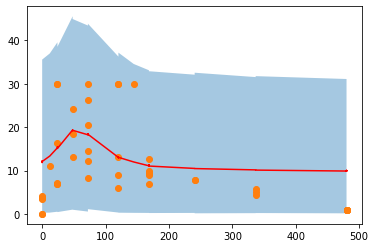

In [64]:
rhoks = svi_samples["y_rhom"]
rhok_mu = jnp.mean(rhoks,axis=0)
rhok_pi = jnp.percentile(rhoks, jnp.array([1, 99]), axis=0)
plt.plot(timel[id_rhom],rhok_mu,color='r')
plt.fill_between(timel[id_rhom],rhok_pi[0,:],rhok_pi[1,:],alpha=0.4)
plt.scatter(timel[id_rhom],dat[2])
# plt.ylim(0,1)
# plt.fill_between(timel[id_rhok],rhok_pi[0],rhok_pi[1])

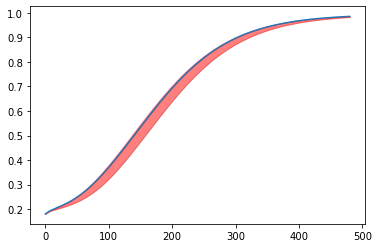

In [69]:
sol = svi_samples["sol"]
sol_mu = jnp.mean(sol,axis=0)
sol_pi = jnp.percentile(sol,jnp.array([0, 100]),axis=0)
plt.plot(timel, sol_mu[0,:])
plt.fill_between(timel, sol_pi[0,0,:],sol_pi[1,0,:],color='r',alpha=0.5)
# plt.scatter(timel[id_rhom],dat[2])

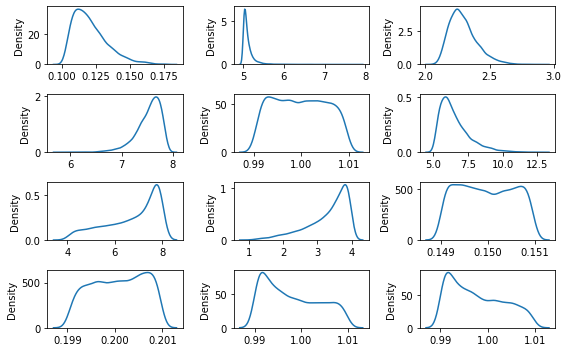

In [66]:
vals = post_samples["v0"]
naxes = vals.shape[1]
fi, axes = plt.subplots(4,3,figsize=(8,5))
axef = axes.flatten()
for i in range(naxes):
    sns.kdeplot(vals[:,i],ax=axef[i])
    # axef[i].set_title(f"{par}")

plt.tight_layout()

In [27]:
rhoks = svi_samples["rhom_dyn"]
rhok_mu = jnp.mean(rhoks,axis=0)
rhok_pi = jnp.percentile(rhoks, jnp.array([1, 99]), axis=0)
plt.plot(timel,rhok_mu,color='r')
plt.fill_between(timel,rhok_pi[0,:],rhok_pi[1,:],alpha=0.4)
plt.scatter(timel[id_rhom],dat[2])
# plt.ylim(0,1)
# plt.fill_between(timel[id_rhok],rhok_pi[0],rhok_pi[1])

KeyError: 'rhom_dyn'